# 1. Prepare

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
import io
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage as sk
import pandas as pd
import cv2
import seaborn as sns

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from imports.utils.log_progress import log_progress
from imports.utils.visualization import Visualize
from imports.utils.enums import DATA_BASE_PATH, RAW_PATH, SHAPE
from imports.utils.utils import rle_encode, rle_decode

from PIL import Image
from PIL import ImageDraw
from matplotlib.pyplot import imshow, imread, imsave
from skimage.draw import line, line_aa, circle
from skimage.util import img_as_float

import xml.etree.ElementTree as ET
import base64
import warnings
warnings.filterwarnings("ignore")

# 2. Read XML's: 

In [3]:
def get_masks_from_xml(xml_tree):
    root = xml_tree.getroot()
    itemlist = root.findall("./ParameterNode/Labels/Item/Value/")
    masks = []
    for item in itemlist:
        if item.attrib["Type"] == "csem.Vision.Labels.FreeFormLabel":
            mask_entry = item.findall("./Mask")
            masks.append(mask_entry[0].text)
    return masks

def get_roots_from_xml(xml_tree):
    root = xml_tree.getroot()
    itemlist = root.findall("./ParameterNode/Labels/Item/Value/")
    roots = []
    for item in itemlist:
        if item.attrib['Type'] == "csem.Vision.Labels.CircularLabel":
            root_entry = item.findall("./BaseClass/Location")
            pX = float(root_entry[0].text.split(",")[0].replace("(",""))
            pY = float(root_entry[0].text.split(",")[1].replace(")",""))
            roots.append([pX,pY])
    return roots

def get_polygons_from_xml(xml_tree):
    root = xml_tree.getroot()
    itemlist = root.findall("./ParameterNode/Labels/Item/Value/")
    splines = []
    for item in itemlist:
        if item.attrib["Type"] == "csem.Vision.Labels.PolygonLabel":
            polygon_entry = item.findall("./Points/Item")
            spline = []
            for p in polygon_entry:  
                pX = float(p.text.split(",")[0].replace("(",""))
                pY = float(p.text.split(",")[1].replace(")",""))
                spline.append([pX,pY])
            splines.append(spline)
    return splines
            

def create_mask(mask_strings,size,min_size=100):
    merged_masks = np.zeros(size,dtype=bool)
    if not len(mask_strings) >= 1:
        return merged_masks
    
    mask_as_bytes = base64.b64decode(mask_strings[0])
    mask = Image.open(io.BytesIO(mask_as_bytes))
    
    for string in mask_strings:
        mask_as_bytes = base64.b64decode(string)
        mask = Image.open(io.BytesIO(mask_as_bytes))
        'Skip masks which are below min_size:'
        if np.sum(np.array(mask) > 0) > min_size:
            merged_masks += np.array(mask) > 0
    return merged_masks
    
    
def create_df():
    imagelist = []
    for path, subdirs, files in os.walk(RAW_PATH):
        for name in files:
            if name.endswith(".png"):
                fullpath = os.path.join(path, name)
                xmlpath = fullpath[:-4]+".xml"
                imagelist.append((path,name,fullpath,xmlpath))
                
    vals = [[] for i in range(6)]
    
    for path,name,fullpath,xmlpath in log_progress(imagelist,every=1):
        img = Image.open(fullpath,mode="r")
        width, height = img.size
        tree = ET.parse(xmlpath)
        masks = get_masks_from_xml(tree)
        mask = create_mask(masks,(height,width))
        rle = rle_encode(mask)
        roots = get_roots_from_xml(tree)
        splines = get_polygons_from_xml(tree)
        vals[0].append(path)
        vals[1].append(name)
        vals[2].append(rle)
        vals[3].append(roots)
        vals[4].append(splines)
        vals[5].append((height,width))

            
    files = {"Path":vals[0],
             "Name":vals[1],
             "Rle-Encoding":vals[2],
             "Roots":vals[3],
             "Splines":vals[4],
             "Shape":vals[5]}
    df = pd.DataFrame.from_dict(files)
    return df

### Load Existing Dataframe

In [4]:
df_labeling_tool = pd.read_pickle(DATA_BASE_PATH+'/df_labeling_tool')

### Create Dataframe of "Raw" Data:

In [7]:
df_labeling_tool = create_df()

### Save Dataframe of "Raw" Data:

In [6]:
df_labeling_tool.to_pickle(DATA_BASE_PATH+"/df_labeling_tool")

### Show Samples of DataFrame:

In [5]:
df_labeling_tool.sample(1)

,Path,Name,Rle-Encoding,Roots,Splines,Shape
392,../data/LabelingTool/Prozessschritte_10,20161013D_hamt370_Ampfer-raw.png,775294 2 776439 13 777585 19 778733 24 779881 ...,"[[617.5631, 806.9285]]","[[[499.1842, 721.3195], [532.4719, 735.0573], ...","(1738, 1151)"


### Show Mask at Index:

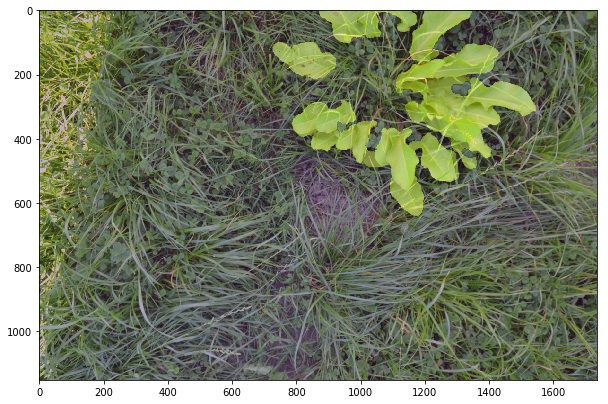

In [6]:
index = 0
mask = rle_decode(df_labeling_tool['Rle-Encoding'][index], df_labeling_tool['Shape'][index])
image = imread(df_labeling_tool['Path'][index] + "/" + df_labeling_tool['Name'][index])
plt.figure(figsize=(10,10))
imshow(mask)
imshow(image,alpha=0.7)

### Show Lines:

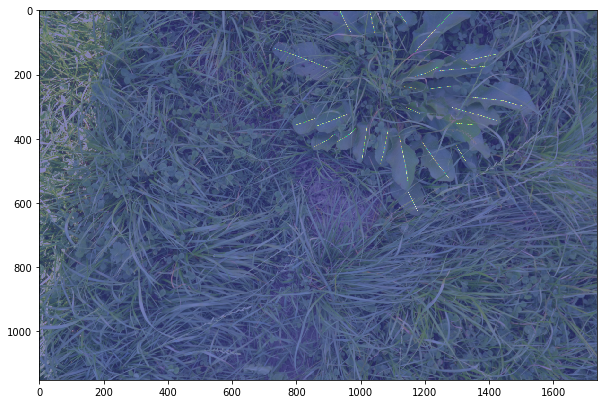

In [7]:
def draw_splines(splines,shape):
    img = np.zeros(shape, dtype=np.uint8)
    for spline in splines:
        s = len(spline)
        for i in range(s-1):
            rr, cc, val = line_aa(int(spline[i][1]), int(spline[i][0]), int(spline[i+1][1]),int(spline[i+1][0]))
            img[rr, cc] = val*255
    return img
   
splines = draw_splines(df_labeling_tool['Splines'][index],df_labeling_tool['Shape'][index])
plt.figure(figsize=(10,10))
imshow(image)
imshow(splines,cmap='terrain',alpha=0.6)

### Show Roots:

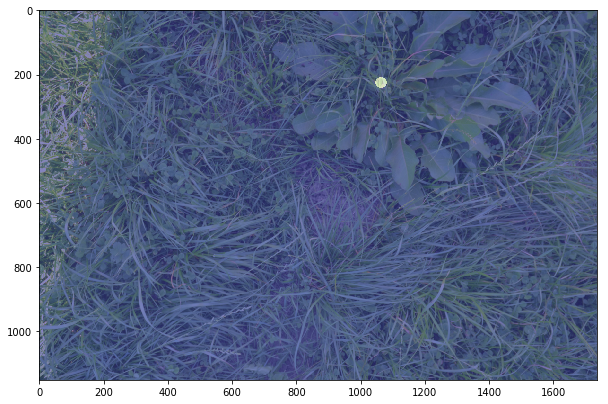

In [50]:
def draw_roots(roots,shape):
    img = np.zeros(shape, dtype=np.uint8)
    for root in roots:
            rr, cc = circle(int(root[1]),int(root[0]),max(shape)/100)
            try:
                img[rr, cc] = 1
            except:
                pass
    return img

roots = draw_roots(df_labeling_tool['Roots'][index],df_labeling_tool['Shape'][index])
plt.figure(figsize=(10,10))
imshow(image)
imshow(roots,cmap='terrain',alpha=0.6)

# 3. Create new Dataframe and save as Standardized Images and Masks:

In [8]:
# Rotates and Resizes Image, Mask, Roots and Splines:
def rotate_and_resize(im,msk,roots,lines,output_size=(1024,1536),scale_factor=1.0,rotate_angle=90):
    #from: https://stackoverflow.com/questions/11764575/python-2-7-3-opencv-2-4-after-rotation-window-doesnt-fit-image
    
    assert rotate_angle == 90 or rotate_angle == 0, "rotate_angle must be 0 or 90°"
    
    oldY = im.shape[0] #note: numpy uses (y,x) convention but most OpenCV functions use (x,y)
    oldX = im.shape[1]
    M = cv2.getRotationMatrix2D(center=(oldX/2,oldY/2), angle=rotate_angle, scale=scale_factor) #rotate about center of image.

    #choose a new image size.
    newX,newY = oldX*scale_factor,oldY*scale_factor
    
    #include this if you want to prevent corners being cut off
    r = np.deg2rad(rotate_angle)
    newX,newY = (abs(np.sin(r)*newY) + abs(np.cos(r)*newX),abs(np.sin(r)*newX) + abs(np.cos(r)*newY))

    #So I will find the translation that moves the result to the center of that region.
    (tx,ty) = ((newX-oldX)/2,(newY-oldY)/2)
    M[0,2] += tx #third column of matrix holds translation, which takes effect after rotation.
    M[1,2] += ty
    
    # Transform image and mask
    im_rotated = cv2.warpAffine(im, M, dsize=(int(newX),int(newY)))
    msk_rotated = cv2.warpAffine(msk, M, dsize=(int(newX),int(newY)))
    
    transformed_lines = []
    for line in lines:
        ones_line = np.ones(shape=(len(line), 1))
        line_ones = np.hstack([line, ones_line])
        transformed_lines.append(M.dot(line_ones.T).T) 
    
    # add ones
    ones_roots = np.ones(shape=(len(roots), 1))

    roots_ones = np.hstack([roots, ones_roots])

    # transform roots and lines
    transformed_roots = M.dot(roots_ones.T).T
    
    if (oldY < oldX and rotate_angle==0) or (oldY > oldX and rotate_angle==90):
        output_size= (output_size[1],output_size[0])
    
    # resize image, mask and roots
    shape_old = im_rotated.shape
    im_rotated = cv2.resize(im_rotated,output_size, interpolation = cv2.INTER_CUBIC)
    msk_rotated = cv2.resize(msk_rotated,output_size, interpolation = cv2.INTER_CUBIC)
    
    ratioX = shape_old[1]/im_rotated.shape[1]
    ratioY = shape_old[0]/im_rotated.shape[0]
    for root in transformed_roots:
        root[0] = root[0] / ratioY
        root[1] = root[1] / ratioX
    for lines in transformed_lines:
        for line in lines:
            line[0] = line[0] / ratioY
            line[1] = line[1] / ratioX
    
    # make sure the image and mask is in range [0,1]
    im_rotated = im_rotated/im_rotated.max()
    msk_rotated = msk_rotated/msk_rotated.max()
    
    return im_rotated, msk_rotated, transformed_roots, transformed_lines

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


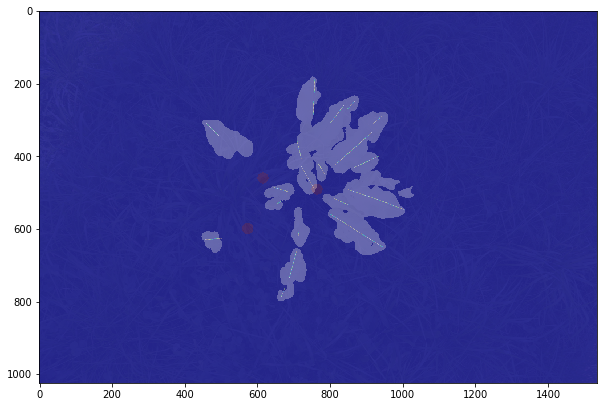

In [9]:
# Show sample:
index = 11

mask = rle_decode(df_labeling_tool['Rle-Encoding'][index], df_labeling_tool['Shape'][index])
image = imread(df_labeling_tool['Path'][index] + "/" + df_labeling_tool['Name'][index])

roots = df_labeling_tool['Roots'][index]
lines = df_labeling_tool['Splines'][index]

plt.figure(figsize=(10,10))
rotated_im, rotated_msk, rotated_roots, rotated_lines = rotate_and_resize(image,mask,roots,lines,rotate_angle=0)

imshow(rotated_im)
imshow(draw_roots(rotated_roots,(rotated_im.shape[0],rotated_im.shape[1])),cmap='jet',alpha=0.8)
imshow(draw_splines(rotated_lines,(rotated_im.shape[0],rotated_im.shape[1])),cmap='terrain',alpha=0.6)
imshow(rotated_msk,cmap='terrain',alpha=0.3)

### Save Data and Create new Dataframe

In [10]:
def save_data(df):
    i = 0
    vals = [[] for i in range(9)]
    for index, image in log_progress(df.iterrows(),every=1,size=len(df)):
        read_path = os.path.join(image['Path'],image['Name'])
        im = imread(read_path)
        msk = rle_decode(image['Rle-Encoding'], image['Shape'])

        roots = image['Roots']
        splines = image['Splines']

        if image['Shape'][0] > image['Shape'][1]:
            im, msk, roots, splines = rotate_and_resize(im,msk,roots,splines,output_size=(1024,1536),rotate_angle=90)
        else:
            im, msk, roots, splines = rotate_and_resize(im,msk,roots,splines,output_size=(1024,1536),rotate_angle=0)

        msk_auto_gen = np.zeros(im.shape, dtype=np.uint8)
        for root in roots:
            rr, cc = circle(int(root[1]), int(root[0]), max(im.shape[0],im.shape[1])/10)
            try:
                msk_auto_gen[rr, cc] = 255
            except:
                pass
        msk_auto_gen = sk.img_as_float(msk_auto_gen)
        
        save_path = '../data/00_all/'
        data_set = 'None'

        name = "img_" + str(1000+i) + ".png"
        image_path = save_path+'images/'
        mask_path = save_path+'masks/'
        mask_circle_path = save_path+'masks_autogen/'
        #print(msk_auto_gen.max())
        vals[0].append(image_path)
        vals[1].append(mask_path)
        vals[2].append(mask_circle_path)
        vals[3].append(name)
        vals[4].append(data_set)
        vals[5].append(rle_encode(msk>0.5))
        vals[6].append(rle_encode(msk_auto_gen>0.5))
        vals[7].append(roots)
        vals[8].append(splines)
        
        #print(im.shape)

        sk.io.imsave(image_path + name,im)
        sk.io.imsave(mask_path + name,msk)
        #sk.io.imsave(mask_circle_path + name,msk_auto_gen)
        i+=1
            
    files = {"image_path":vals[0],
             "mask_path":vals[1],
             "mask_cirlce_path":vals[2],
             "name":vals[3],
             "dataset":vals[4],
             "mask_rle":vals[5],
             "mask_circle_rle":vals[6],
             "roots":vals[7],
             "splines":vals[8]}
    return pd.DataFrame.from_dict(files)

### Save:

In [12]:
df = save_data(df_labeling_tool)

In [9]:
df = pd.read_pickle(DATA_BASE_PATH+'/df')

In [10]:
df.sample(1)

,image_path,mask_path,mask_cirlce_path,name,dataset,mask_rle,mask_circle_rle,roots,splines
260,../data/00_all/images/,../data/00_all/masks/,../data/00_all/masks_autogen/,img_1260.png,None,19307 1 19309 3 20841 9 22376 12 23911 14 2543...,942499 81 947080 135 951670 171 956263 201 960...,"[[835.0048780487805, 357.3816911883589]]","[[[857.4257951219512, 77.62623637833468], [868..."


In [13]:
df.to_pickle(DATA_BASE_PATH+"/df")

#### Create Autogenerated Masks:

In [16]:
from scipy import ndimage as ndi
from matplotlib.pyplot import imshow, imread, imsave
from skimage.transform import rescale, resize
for index, row in df.iterrows():
            img = imread(row['image_path']+row['name'])
            msk = imread(row['mask_path']+row['name'])
            border = 300
            msk_circle = np.zeros((1024+border,1536+border))
            for root in row['roots']:
                rr, cc = circle(int(root[1]), int(root[0]), 200)
                rr += int(border/2)
                cc += int(border/2)
                try:
                    msk_circle[rr, cc] = 1.0
                except:
                    pass
            msk_circle = msk_circle[int(border/2):-int(border/2),int(border/2):-int(border/2)]
            msk_circle = resize(msk_circle,(1024,1536))
            msk_circle = ndi.distance_transform_edt(msk_circle)
            msk_circle = msk_circle/msk_circle.max()
            imsave(DATA_BASE_PATH+"/00_all/masks_autogen/" +row['name'],msk_circle,cmap="gray")

### Load Splited Data

In [11]:
train_df = pd.read_pickle(DATA_BASE_PATH+'/train_df')
val_df = pd.read_pickle(DATA_BASE_PATH+'/val_df')
test_df = pd.read_pickle(DATA_BASE_PATH+'/test_df')

print("Number of training Samples:", len(train_df))
print("Number of validation Samples:", len(val_df))
print("Number of test Samples:", len(test_df))

Number of training Samples: 354
Number of validation Samples: 102
Number of test Samples: 51


### DONT DO THIS!

In [52]:
# shuffle
import math
df_shuffeled = df.sample(frac=1)
train_size = 0.8
val_size = 0.2
test_size = 0.0
samples = len(df_shuffeled)

train_ind = math.floor(samples*train_size)
val_ind = train_ind + math.floor(samples*val_size)
test_ind = train_ind + val_ind + math.floor(samples*test_size)

train_df = df_shuffeled[0:train_ind].reset_index(drop=True)
val_df = df_shuffeled[train_ind:val_ind+1].reset_index(drop=True)
test_df = df_shuffeled[val_ind:-1].reset_index(drop=True)

print("Number of training Samples:", len(train_df))
print("Number of validation Samples:", len(val_df))
print("Number of test Samples:", len(test_df))

Number of training Samples: 405
Number of validation Samples: 102
Number of test Samples: 0


In [53]:
train_df.to_pickle(DATA_BASE_PATH+"/train_df")
val_df.to_pickle(DATA_BASE_PATH+"/val_df")
test_df.to_pickle(DATA_BASE_PATH+"/test_df")

### 4.1 Roots per Image:

In [12]:
df_all = pd.concat([train_df.assign(dataset='train'), val_df.assign(dataset='val'), test_df.assign(dataset='test')])

Text(0.5,1,'Distribution of Roots per Image')

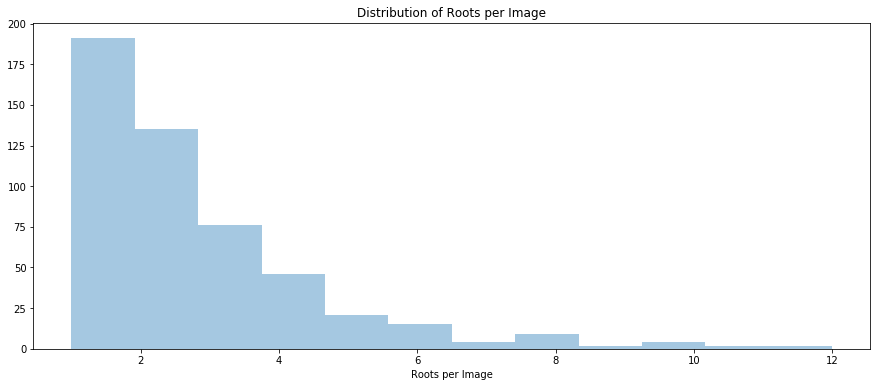

In [13]:
x = df_all[['roots']].apply (lambda row: len(row['roots']), axis=1)
x = pd.Series(x, name="Roots per Image")
plt.figure(figsize=(15,6))
sns.distplot(x,bins=12, kde=False, rug=False).set_title("Distribution of Roots per Image")

### 4.2 Visualize Root Distribution:

In [39]:
#create temporary dataframe:
x_roots = []
y_roots = []
paths = []
for _,row in df_all.iterrows():
    for root in row['roots']:
        x_roots.append(root[0])
        y_roots.append(root[1])
        paths.append(row['dataset'])
        
root_coordinates = [('x', x_roots),
                 ('y', y_roots),
                    ('dataset',paths)]
df_root_coordinates = pd.DataFrame.from_items(root_coordinates)
df_root_coordinates.sample(3)

,x,y,dataset
654,855.233679,401.807613,train
1142,459.437840,55.304891,test
164,742.192390,381.338386,train


Text(0.5, 1.0, 'Distribution of Root-Coordinates in Images')

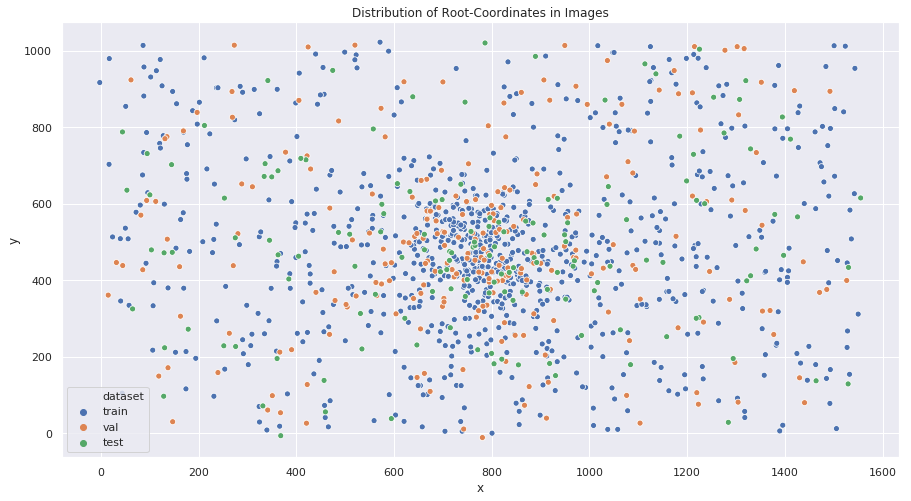

In [40]:
plt.figure(figsize=(15,8))
sns.set(style="darkgrid")
ax = sns.scatterplot(x="x", y="y",hue="dataset", data=df_root_coordinates)
ax.set_title("Distribution of Root-Coordinates in Images")

### 4.3 Visualize Mask Distribution:

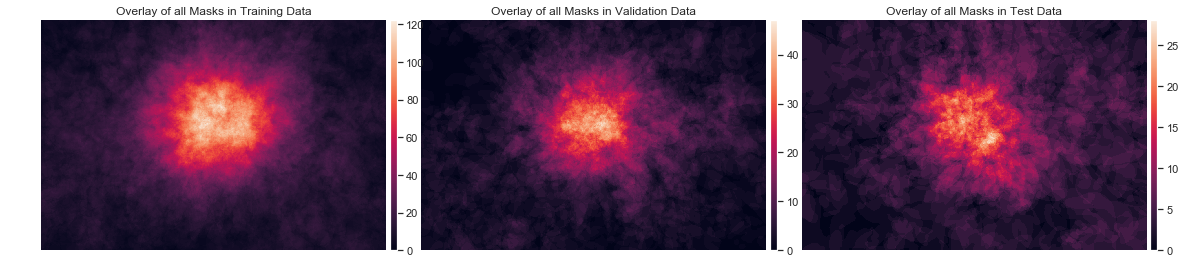

In [21]:
shape = (1024,1536)
summed_mask_train = np.zeros(shape)
summed_mask_val = np.zeros(shape)
summed_mask_test = np.zeros(shape)
for i,row in df_all.iterrows():
    if row['dataset'] == 'train':
        summed_mask_train += rle_decode(row['mask_rle'],shape)
    if row['dataset'] == 'val':
        summed_mask_val += rle_decode(row['mask_rle'],shape)
    if row['dataset'] == 'test':
        summed_mask_test += rle_decode(row['mask_rle'],shape)

from mpl_toolkits.axes_grid1 import make_axes_locatable        
        
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(20,20))
im0 = axs[0].imshow(summed_mask_train)
im1 = axs[1].imshow(summed_mask_val)
im2 = axs[2].imshow(summed_mask_test)
axs[0].set_title('Overlay of all Masks in Training Data')
axs[0].axis('off')
axs[1].set_title('Overlay of all Masks in Validation Data')
axs[1].axis('off')
axs[2].set_title('Overlay of all Masks in Test Data')
axs[2].axis('off')

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')


plt.subplots_adjust(wspace=0.07, hspace=0)

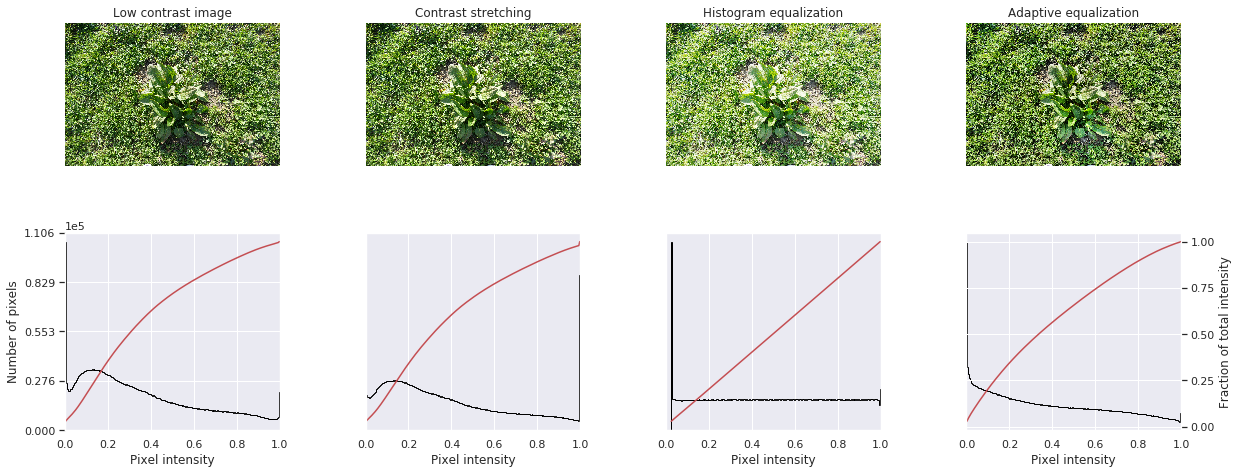

In [41]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = imread(DATA_BASE_PATH + "/05_test/images/P1170171.JPG")
img = resize(img,(1024,1536))

# Contrast stretching
p2 = np.percentile(img, 2)
p98 = np.percentile(img, 98)
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
f, axes = plt.subplots(2, 4, figsize=(20, 8))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
plt.subplots_adjust(wspace=0.4)
plt.show()

In [16]:
df.sample(1)

,image_path,mask_path,mask_cirlce_path,name,dataset,mask_rle,mask_circle_rle,roots,splines
132,../data/00_all/images/,../data/00_all/masks/,../data/00_all/masks_autogen/,img_1132.png,None,337146 8 338663 32 340193 42 341718 55 343252 ...,481732 81 486313 135 490903 171 495496 201 500...,"[[822.3775138140745, 627.8241804372842], [846....","[[[798.2651162467419, 252.9507424626007], [763..."


In [51]:
img = None
for i,row in df.iterrows():
    img = imread(row['image_path'] + row['name'])
    root_mask = draw_roots(row['roots'],(1024,1536))
    root_mask = root_mask.astype(float)
    root_mask /= 255.
    root_mask /= root_mask.max()
    img[:,:,0] += root_mask
    img[:,:,1] += root_mask
    img[:,:,2] += root_mask
    imsave('../data/00_all/images_with_roots/' + row['name'],img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


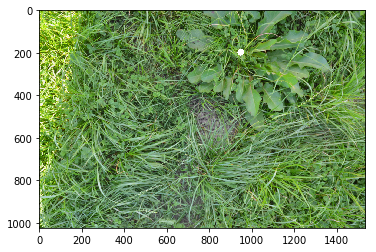

In [47]:
imshow(img)